# My parkruns

Notebook to view my personal parkrun data.

N.B. parkrun results are Copyright (c) parkrun and results are made available for *personal, non-commercial use only*.

### Import libraries

In [471]:
import pandas as pd
import numpy as np
import pickle
from glob import glob
from urllib.request import Request, urlopen

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.2)

#### Function to read my results from website

This is for one-off use, as automated scraping is not permitted (see https://www.parkrun.org.uk/robots.txt for details).

In [472]:
def read_rundata_for_(athlete) :
    
    # headers for user-agent
    myHeaders = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.87 Safari/537.36', 'Referer': 'https://www.nseindia.com', 'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8'}

    # read html
    url='http://www.parkrun.org.uk/results/athleteeventresultshistory/?athleteNumber='+str(athlete)+'&eventNumber=0'
    url_request  = Request(url, headers=myHeaders)
    data = urlopen(url_request)
    tables = pd.read_html(data)
    
    # return table of results
    rundata = tables[2]
    
    return rundata

#### Function to convert Time from string to timedelta

In [473]:
# convert time string to timedelta
def timestr_to_timedelta(timestr) :
    if len(timestr.split(':')) == 2 : # add hour value if only minutes shown
        time = pd.to_timedelta('00:'+timestr)
    else :
        time = pd.to_timedelta(timestr)
    return time

#### Functions to read and write df to pickle

In [2]:
def write_pkl(fname, df):
    with open(fname,'wb') as pklf:
        pickle.dump((df), pklf)
        print('Saved to', fname)
        
def read_pkl(fname):
    with open(fname,'rb') as pklf:
        df = pickle.load(pklf)
    return df

### ONE-OFF: Read my results from the parkrun website

In [19]:
athlete=190393 # this is me!

rundata = read_rundata_for_(athlete=athlete)

# Convert dates and times to datetime
rundata['Run Date'] = rundata['Run Date'].apply(lambda x: pd.to_datetime(x).date())
rundata['Time'] = rundata['Time'].apply(lambda x: timestr_to_timedelta(x))

# Remove % sign from age grade
rundata['AgeGrade'] = rundata['AgeGrade'].apply(lambda x: float(x.strip('%')))

# write dataframe to pickle
f = 'rundata/my_parkrun_data.pkl'
write_pkl(f, rundata)

Saved to rundata/my_parkrun_data.pkl


### Read my results from pickle

In [474]:
rundata = read_pkl('./rundata/my_parkrun_data.pkl')
rundata.head()

,Event,Run Date,Run Number,Pos,Time,AgeGrade,PB?
0,Hasenheide,2020-08-02,112,36,00:22:42,65.20,NaN
1,Wimpole Estate,2019-09-28,333,58,00:23:38,62.62,NaN
2,Wimpole Estate,2019-08-31,330,60,00:23:42,62.45,NaN
3,Wimpole Estate,2019-08-24,329,76,00:24:02,61.58,NaN
4,Wimpole Estate,2019-08-17,328,39,00:23:30,62.98,NaN


### Take a look at my attendence

....it's sporadic!

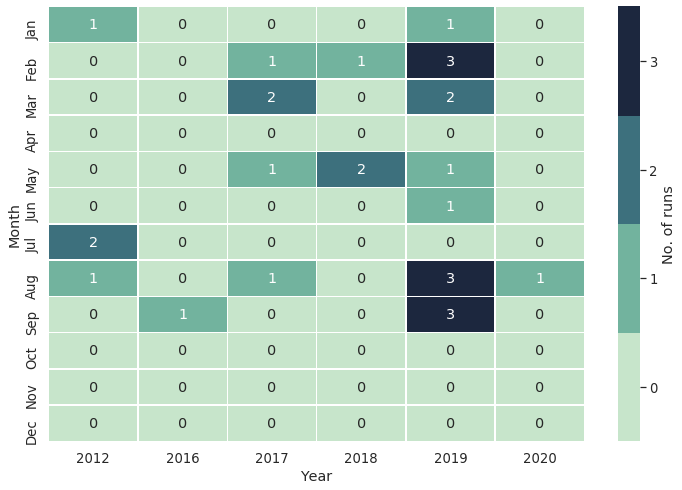

In [475]:
fig, ax = plt.subplots(figsize=(12, 8))

# extract year and month
rundata['Year'] = pd.to_datetime(rundata['Run Date']).dt.year
rundata['Month'] = pd.to_datetime(rundata['Run Date']).dt.month_name().str.slice(stop=3) # .month for int month

# pivot df into long form and aggregate simply by number of runs (len)
rundata_long = rundata.pivot_table(index='Month', columns='Year', values='Time', aggfunc=len, fill_value=0).astype(int)

# add rows of zeros for any months missed
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
for month in months:
    if month not in rundata_long.index.values :
        rundata_long.loc[month] = 0
# sort chronological
rundata_long = rundata_long.reindex(months)

# Plot number of runs by month/year
maxruns=rundata_long.max().max()
cmap = sns.cubehelix_palette(rot=-.4, n_colors=maxruns+1)

ticks=np.arange(0,maxruns+1)
boundaries = np.arange(-0.5,maxruns+1.5 )

ax = sns.heatmap(rundata_long, annot=True, linewidths=0.4, cmap=cmap,
                 cbar_kws={"ticks":ticks, "boundaries":boundaries,'label': 'No. of runs'})

plt.show()

### Take a look at my times and age grades

Fit a quick linear regression model to age grades to see if improving with age! (use *robust=True* to downweight outliers)

#### Age Grading (from parkrun.com)

Age grading takes your time and uses the world record time for your sex and age to produce a score (a percentage). This score allows you to compare your personal performance against other people's performances even though they might be a different age and a different sex to you - the higher the score the better the performance:
* 100% Approximate world record level
* Above 90% World Class Level
* Above 80% National Class Level
* Above 70% Regional Class Level
* Above 60% Local Class Level

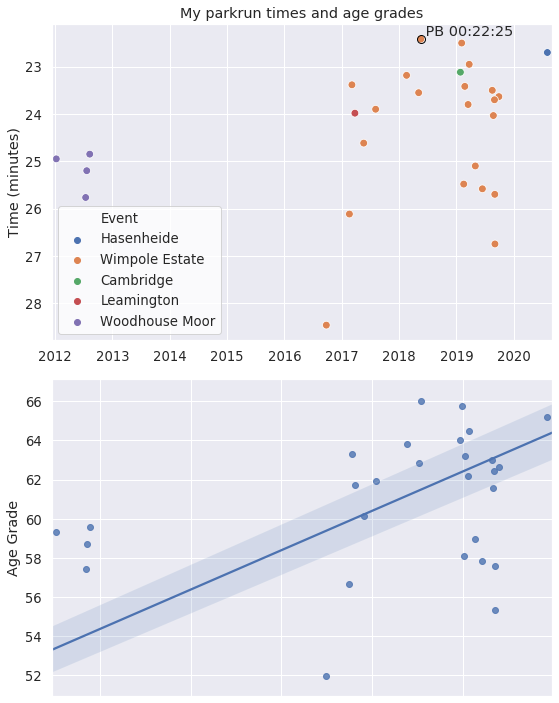

In [476]:
# Extract times in minutes
times=(rundata['Time'] / pd.Timedelta(minutes=1))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot scatterplot of times
sns.scatterplot(x=rundata['Run Date'], y=times, hue=rundata['Event'], s=60, ax=ax1)
ax1.set(xlabel='', ylabel="Time (minutes)", title="My parkrun times and age grades")

# Flip y axis (fastest times at top!) and
# set x limits a month either side of run dates
xmin = rundata['Run Date'].min()-pd.to_timedelta(1, unit='M')
xmax = rundata['Run Date'].max()+pd.to_timedelta(1, unit='M')
ax1.set_xlim(xmin, xmax)
ax1.invert_yaxis()
ax1.legend(loc='best', facecolor='white')

# Highlight all-time PB!
PBtime = (rundata['Time'].min()/pd.Timedelta(minutes=1))
PBdate = rundata[rundata['Time'] == rundata['Time'].min()]['Run Date']
ax1.plot(PBdate, PBtime, marker='o', markersize=8, color='black', fillstyle='none')
PBtimestr = str(rundata.groupby(['Event'])['Time'].min().min()).split()[2]
ax1.text(PBdate, PBtime, ' PB '+PBtimestr, horizontalalignment='left', verticalalignment='bottom')

# Plot age grades and fit quick linear regression
rundata['Run Date Numeric'] = pd.to_numeric(pd.to_datetime(rundata['Run Date']))
sns.regplot(x='Run Date Numeric', y='AgeGrade', data=rundata, ax=ax2)
ax2.set(ylabel="Age Grade", xlabel='')
lims = pd.Series(np.array([xmin,xmax]))
ax2.set_xlim(pd.to_numeric(pd.to_datetime(lims)).iloc[0], pd.to_numeric(pd.to_datetime(lims)).iloc[1])
ax2.set_xticklabels('')

plt.tight_layout()

#### View the distribution

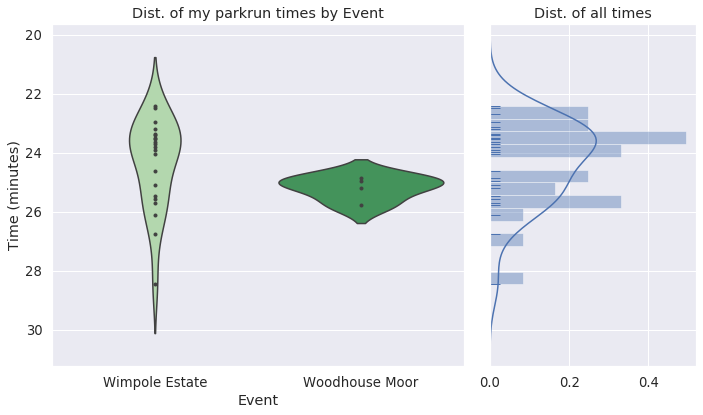

In [477]:
# select only events with more than one run
rundata_multi = rundata[rundata['Event'].duplicated(keep=False)]
n_events=len(rundata_multi['Event'].unique())
# Extract times in minutes
times_multi=(rundata_multi['Time'] / pd.Timedelta(minutes=1))

fig, (ax1, ax2)  = plt.subplots(1, 2, sharey=True, figsize=(10, 6), gridspec_kw={'width_ratios': [n_events, 1]})

# violin plot of times for each event
sns.violinplot(x=rundata_multi['Event'], y=times_multi, inner="points", palette="Greens", ax=ax1)
ax1.set(ylabel="Time (minutes)", title="Dist. of my parkrun times by Event")

# distplot of all run times
sns.distplot(times, bins=14, rug=True, vertical=True, ax=ax2)
ax2.set(ylabel='', title='Dist. of all times')

ax1.invert_yaxis()
ax2.invert_yaxis()
plt.tight_layout()

### Take a look at best times through the year

Can't really check for seasonality - not enough data... need to run more!

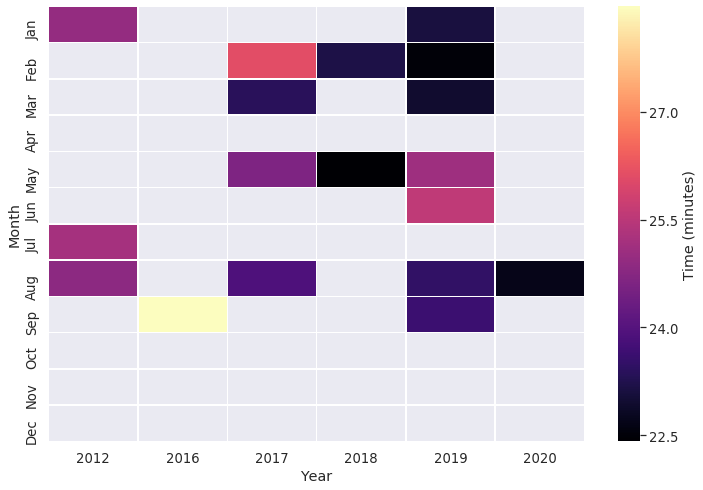

In [501]:
fig, ax = plt.subplots(figsize=(12, 8))

# pivot df into long form and aggregate by fastest time
rundata_long = (rundata.pivot_table(index='Month', columns='Year', values='Time', aggfunc=np.min, fill_value=np.nan) / pd.Timedelta(minutes=1))
# add rows of zeros for any months missed
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
for month in months:
    if month not in rundata_long.index.values :
        rundata_long.loc[month] = np.nan
# sort chronological
rundata_long = rundata_long.reindex(months)

sns.heatmap(rundata_long, linewidths=0.4,
            cmap='magma', cbar_kws={'label': 'Time (minutes)'}, ax=ax)

plt.show()